In [1]:
import os

import pandas as pd
import numpy as np
import math

import torch

torch.set_default_dtype(torch.double)

import torch.nn.functional as F
import gpytorch

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8, 6)

import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
csv_path = "../data/DB_10042.csv"
node_sim_path = "../data/DB_10042_node_sims2.npy"
linker_sim_path = "../data/DB_10042_linker_sims2.npy"

In [3]:
df = pd.read_csv(csv_path, index_col=0).iloc[:, 25:]
df

/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_12671/1105716100.py:1: DtypeWarning: Columns (2,3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, index_col=0).iloc[:, 25:]


,M_N_ratio,POvolume(cm^3/g),POVolumefraction,SurfaceArea(m^2/g),PoreDi(angstrom),PoreDif(angstrom),mean,std,median,mode,...,99,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9
ECODEG_clean_CHG,0.038462,0.295739,0.39878,1356.71,5.33632,5.31165,5.172686,0.304880,5.3,5.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NERVEN_clean_CHG,0.021739,0.358478,0.38728,1422.45,12.25139,12.25139,9.371512,2.496661,9.8,12.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAKJOO_clean_CHG,0.040000,0.504431,0.50690,2100.01,7.70901,7.70901,7.159028,0.773964,7.3,7.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WAFKIY_clean_CHG,0.028571,0.617188,0.60282,2431.42,7.94426,7.94140,7.973259,0.154186,7.9,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NEJSEC_clean_CHG,0.038462,0.283353,0.35208,1389.91,5.81645,5.23805,4.670497,0.854686,4.4,4.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SR_tfp_v1-3c_triazine_Ch_v2-4c_Cu_1_Ch_v3-3c_B_Ch_1B_4CN_Ch_1x1x2,0.016949,3.669030,0.86338,4875.65,37.21847,37.21847,32.708699,8.849995,37.2,37.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SR_cdle_v1-4c_B_Ch_v2-4c_1anC_Ch_v3-4c_Cu_1_Ch_1B_2F_Ch_2x2x1,0.035398,1.244090,0.73028,3850.61,9.67494,9.61379,9.605040,0.480719,9.7,9.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OPT_lnj_sym_3_on_1_sym_7_mc_4_1B_2CH3_ntn_edge,0.019868,1.493000,0.72804,4561.61,13.88829,13.88829,12.795836,1.570440,13.6,13.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OPT_mcn_sym_6_mc_3_sym_3_on_2_ntn_edge_1B_4CN_ntn_edge,0.043011,0.558638,0.50864,2288.87,9.30713,8.44460,8.377851,1.447078,8.8,8.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
list(df.columns)

['M_N_ratio',
 'POvolume(cm^3/g)',
 'POVolumefraction',
 'SurfaceArea(m^2/g)',
 'PoreDi(angstrom)',
 'PoreDif(angstrom)',
 'mean',
 'std',
 'median',
 'mode',
 '0',
 '0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '1',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1.9',
 '2',
 '2.1',
 '2.2',
 '2.3',
 '2.4',
 '2.5',
 '2.6',
 '2.7',
 '2.8',
 '2.9',
 '3',
 '3.1',
 '3.2',
 '3.3',
 '3.4',
 '3.5',
 '3.6',
 '3.7',
 '3.8',
 '3.9',
 '4',
 '4.1',
 '4.2',
 '4.3',
 '4.4',
 '4.5',
 '4.6',
 '4.7',
 '4.8',
 '4.9',
 '5',
 '5.1',
 '5.2',
 '5.3',
 '5.4',
 '5.5',
 '5.6',
 '5.7',
 '5.8',
 '5.9',
 '6',
 '6.1',
 '6.2',
 '6.3',
 '6.4',
 '6.5',
 '6.6',
 '6.7',
 '6.8',
 '6.9',
 '7',
 '7.1',
 '7.2',
 '7.3',
 '7.4',
 '7.5',
 '7.6',
 '7.7',
 '7.8',
 '7.9',
 '8',
 '8.1',
 '8.2',
 '8.3',
 '8.4',
 '8.5',
 '8.6',
 '8.7',
 '8.8',
 '8.9',
 '9',
 '9.1',
 '9.2',
 '9.3',
 '9.4',
 '9.5',
 '9.6',
 '9.7',
 '9.8',
 '9.9',
 '10',
 '10.1',
 '10.2',
 '10.3',
 '10.4',
 '10.5',
 '10.6',


In [5]:
list(df.columns)[10:]

['0',
 '0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '1',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1.9',
 '2',
 '2.1',
 '2.2',
 '2.3',
 '2.4',
 '2.5',
 '2.6',
 '2.7',
 '2.8',
 '2.9',
 '3',
 '3.1',
 '3.2',
 '3.3',
 '3.4',
 '3.5',
 '3.6',
 '3.7',
 '3.8',
 '3.9',
 '4',
 '4.1',
 '4.2',
 '4.3',
 '4.4',
 '4.5',
 '4.6',
 '4.7',
 '4.8',
 '4.9',
 '5',
 '5.1',
 '5.2',
 '5.3',
 '5.4',
 '5.5',
 '5.6',
 '5.7',
 '5.8',
 '5.9',
 '6',
 '6.1',
 '6.2',
 '6.3',
 '6.4',
 '6.5',
 '6.6',
 '6.7',
 '6.8',
 '6.9',
 '7',
 '7.1',
 '7.2',
 '7.3',
 '7.4',
 '7.5',
 '7.6',
 '7.7',
 '7.8',
 '7.9',
 '8',
 '8.1',
 '8.2',
 '8.3',
 '8.4',
 '8.5',
 '8.6',
 '8.7',
 '8.8',
 '8.9',
 '9',
 '9.1',
 '9.2',
 '9.3',
 '9.4',
 '9.5',
 '9.6',
 '9.7',
 '9.8',
 '9.9',
 '10',
 '10.1',
 '10.2',
 '10.3',
 '10.4',
 '10.5',
 '10.6',
 '10.7',
 '10.8',
 '10.9',
 '11',
 '11.1',
 '11.2',
 '11.3',
 '11.4',
 '11.5',
 '11.6',
 '11.7',
 '11.8',
 '11.9',
 '12',
 '12.1',
 '12.2',
 '12.3',
 '12.4',
 

In [6]:
features = torch.tensor(df.values)
numerical_features = features[:, :6]
distributional_features = features[:, 10:]

# distributional_features = distributional_features[:, distributional_features.std(dim=0) > 0]
# numerical_features = torch.hstack(
#     [numerical_features, distributional_features]
# )

# normalize each numerical column
numerical_features = (numerical_features - numerical_features.mean(dim=0)) / numerical_features.std(dim=0)
numerical_features.shape

torch.Size([10042, 6])

In [7]:
class NumericalKernel(gpytorch.kernels.Kernel):
    def __init__(self, base_kernel, numerical_features):
        super().__init__()
        self.base_kernel = base_kernel
        self.numerical_features = numerical_features
        
    def forward(self, x1_ind, x2_ind, **params):
        return self.base_kernel(
            self.numerical_features[x1_ind.squeeze(), :],
            self.numerical_features[x2_ind.squeeze(), :],
            **params
        )
    
    
numerical_kernel = NumericalKernel(
    gpytorch.kernels.RBFKernel(ard_dim_nums=numerical_features.size(-1)), 
    numerical_features,
)

numerical_kernel(torch.tensor([0, 1], dtype=torch.long)).evaluate()

tensor([[1.0000, 0.1279],
        [0.1279, 1.0000]], grad_fn=<RBFCovarianceBackward>)

In [8]:
numerical_covariance_matrix = numerical_kernel(
    torch.arange(df.shape[0], dtype=torch.long)
).evaluate().detach().numpy()

In [9]:
numerical_covariance_matrix[:5, :5]

array([[1.        , 0.12787344, 0.43921102, 0.13989223, 0.94584817],
       [0.12787344, 1.        , 0.21258184, 0.08921099, 0.13858796],
       [0.43921102, 0.21258184, 1.        , 0.71366101, 0.34813281],
       [0.13989223, 0.08921099, 0.71366101, 1.        , 0.091214  ],
       [0.94584817, 0.13858796, 0.34813281, 0.091214  , 1.        ]])

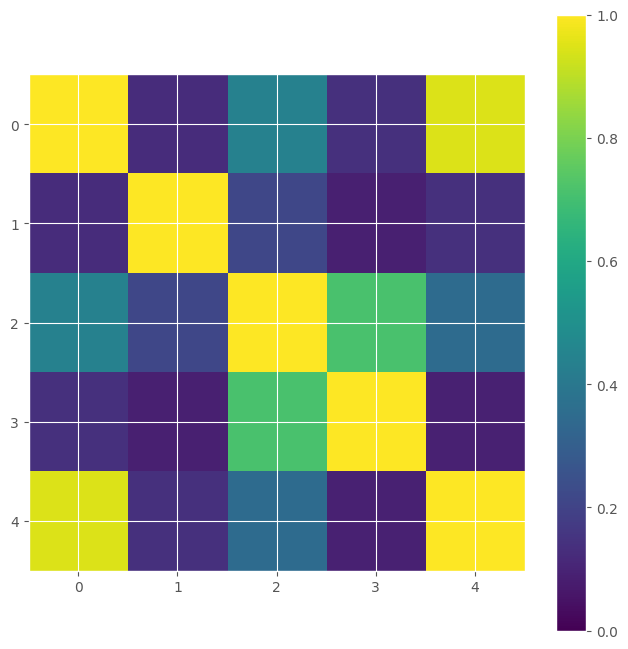

In [10]:
plt.figure(figsize=(8, 8))

plt.imshow(numerical_covariance_matrix[:5, :5], vmin=0, vmax=1)
plt.colorbar();

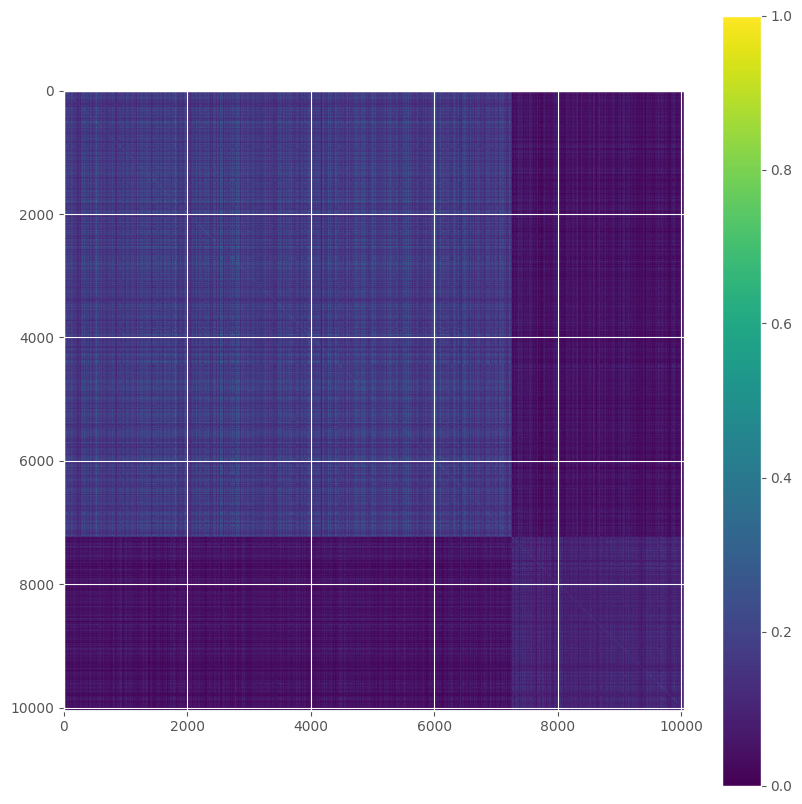

In [11]:
assert (
    (numerical_covariance_matrix >= 0).all() 
    and (numerical_covariance_matrix <= 1).all()
)

plt.figure(figsize=(10, 10))

plt.imshow(numerical_covariance_matrix, vmin=0, vmax=1)
plt.colorbar();

In [12]:
alpha = 1e-8
smoothed_distributional_features = distributional_features + alpha
smoothed_distributional_features = F.normalize(smoothed_distributional_features, p=1, dim=1)
assert torch.isclose(
    smoothed_distributional_features.sum(dim=1), 
    torch.ones(1, dtype=smoothed_distributional_features.dtype)
).all()

In [13]:
mean = (
    smoothed_distributional_features[0, :] 
    + smoothed_distributional_features[2, :]
) / 2

(
    F.kl_div(
        torch.log(smoothed_distributional_features[2, :]), 
        torch.log(mean),
        log_target=True,
    ) + F.kl_div(
        torch.log(smoothed_distributional_features[0, :]), 
        torch.log(mean),
        log_target=True,
    )
) / 2

/Users/quannguyen/anaconda3/envs/mof_search/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(0.0042)

In [14]:
def vectorized_js_div(a, b):
    assert len(a.size()) == len(b.size()) == 2
    
    expanded_a = a[:, None, :]
    expanded_b = b[None, ...]
    m = (expanded_a + expanded_b) / 2
    
    am_div = (m * (torch.log(m) - torch.log(expanded_a))).mean(dim=-1)
    bm_div = (m * (torch.log(m) - torch.log(expanded_b))).mean(dim=-1)
    
    return (am_div + bm_div) / 2


class JSKernel(gpytorch.kernels.Kernel):
    def forward(self, x1, x2, **params):
        js_div = vectorized_js_div(x1, x2)
        
        return 1 - js_div / math.log(2)
    

class DistributionalKernel(gpytorch.kernels.Kernel):
    def __init__(self, base_kernel, smoothed_distributional_features):
        assert (smoothed_distributional_features > 0).all()
        
        super().__init__()
        self.base_kernel = base_kernel
        self.smoothed_distributional_features = smoothed_distributional_features
        
    def forward(self, x1_ind, x2_ind, show_progress=False, **params):
        return self.base_kernel(
            self.smoothed_distributional_features[x1_ind.squeeze(), :],
            self.smoothed_distributional_features[x2_ind.squeeze(), :],
            **params
        )

In [15]:
js_kernel = JSKernel()
distributional_kernel = DistributionalKernel(
    js_kernel, smoothed_distributional_features
)

distributional_kernel(
    torch.tensor([0, 1, 2], dtype=torch.long),
    # torch.tensor([3, 4, 5], dtype=torch.long)
).evaluate()

tensor([[1.0000, 0.9937, 0.9939],
        [0.9937, 1.0000, 0.9961],
        [0.9939, 0.9961, 1.0000]])

In [16]:
df.shape[0]

10042

In [17]:
full_dist_covariance_matrix = torch.zeros((df.shape[0], df.shape[0]))

increment = 100

for i1 in tqdm(range(math.ceil(df.shape[0] / increment))):
    for i2 in range(i1, math.ceil(df.shape[0] / increment)):
        expanded_i1 = torch.arange(
            i1 * increment, 
            min(i1 * increment + increment, df.shape[0]), 
            dtype=torch.long,
        )
        expanded_i2 = torch.arange(
            i2 * increment, 
            min(i2 * increment + increment, df.shape[0]), 
            dtype=torch.long,
        )
        
        this_dist_covariance_matrix = distributional_kernel(
            expanded_i1, expanded_i2
        ).evaluate().detach()
        
        # full_dist_covariance_matrix[expanded_i1, :][:, expanded_i2] = this_dist_covariance_matrix
        # full_dist_covariance_matrix[expanded_i2, :][:, expanded_i1] = this_dist_covariance_matrix.mT
        full_dist_covariance_matrix.index_put_(
            (
                expanded_i1.unsqueeze(-1).expand(
                    expanded_i1.numel(), expanded_i2.numel()
                ).flatten(),
                expanded_i2.expand(
                    expanded_i1.numel(), expanded_i2.numel()
                ).flatten()
            ),
            this_dist_covariance_matrix.flatten()
        )
        
        full_dist_covariance_matrix.index_put_(
            (
                expanded_i2.unsqueeze(-1).expand(
                    expanded_i2.numel(), expanded_i1.numel()
                ).flatten(),
                expanded_i1.expand(
                    expanded_i2.numel(), expanded_i1.numel()
                ).flatten()
            ),
            this_dist_covariance_matrix.mT.flatten()
        )

  0%|          | 0/101 [00:00<?, ?it/s]

In [18]:
full_dist_covariance_matrix

tensor([[1.0000, 0.9937, 0.9939,  ..., 0.9928, 0.9939, 0.9899],
        [0.9937, 1.0000, 0.9961,  ..., 0.9954, 0.9968, 0.9941],
        [0.9939, 0.9961, 1.0000,  ..., 0.9934, 0.9952, 0.9930],
        ...,
        [0.9928, 0.9954, 0.9934,  ..., 1.0000, 0.9940, 0.9954],
        [0.9939, 0.9968, 0.9952,  ..., 0.9940, 1.0000, 0.9936],
        [0.9899, 0.9941, 0.9930,  ..., 0.9954, 0.9936, 1.0000]])

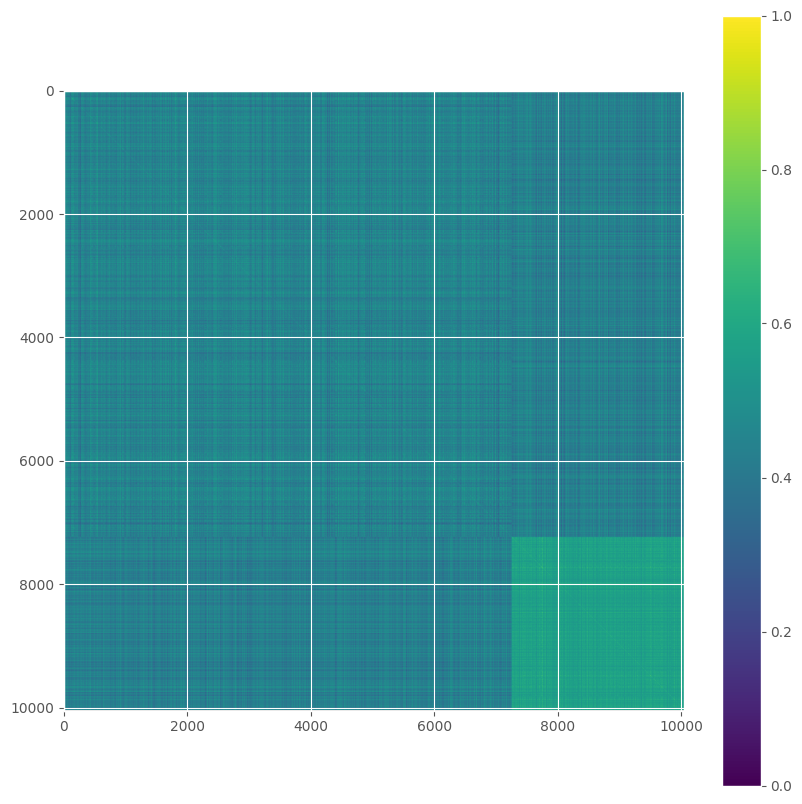

In [19]:
assert (
    (full_dist_covariance_matrix >= 0).all() 
    and (full_dist_covariance_matrix <= 1).all()
)

norm_full_dist_covariance_matrix = (
    full_dist_covariance_matrix 
    - full_dist_covariance_matrix.min()
) / (
    full_dist_covariance_matrix.max() 
    - full_dist_covariance_matrix.min()
)

plt.figure(figsize=(10, 10))

plt.imshow(norm_full_dist_covariance_matrix, vmin=0, vmax=1)
plt.colorbar();

In [20]:
np.save(
    "../data/DB_10042_distributional_sims.npy", 
    full_dist_covariance_matrix.detach().numpy(),
)

# unvectorized

In [23]:
class JSDDistance(gpytorch.kernels.Kernel):
    def forward(self, x1, x2, **params):
        assert x1.numel() == x2.numel() == 1000
        x1 = x1.squeeze()
        x2 = x2.squeeze()
        
        m = (x1 + x2) / 2
        
        # positive_mask = (m > 0)
        # positive_m = m[positive_mask]
        # positive_x1 = x1[positive_mask]
        # positive_x2 = x2[positive_mask]
        
        # print(F.kl_div(torch.log(positive_x1), torch.log(positive_m), log_target=True))
        # print(F.kl_div(torch.log(positive_x2), torch.log(positive_m), log_target=True))
        
        # result = (
        #     F.kl_div(torch.log(positive_x1), torch.log(positive_m), log_target=True)
        #     + F.kl_div(torch.log(positive_x2), torch.log(positive_m), log_target=True)
        # ) / 2
        
        result = (
            F.kl_div(torch.log(x1), torch.log(m), log_target=True)
            + F.kl_div(torch.log(x2), torch.log(m), log_target=True)
        ) / 2
        
        return result.unsqueeze(dim=0).unsqueeze(0)

class DistributionalKernel(gpytorch.kernels.Kernel):
    def __init__(self, base_kernel, smoothed_distributional_features):
        assert (smoothed_distributional_features > 0).all()
        
        super().__init__()
        self.base_kernel = base_kernel
        self.smoothed_distributional_features = smoothed_distributional_features
        
    def forward(self, x1_ind, x2_ind, show_progress=False, **params):
        x1_ind = x1_ind.squeeze().detach().numpy().tolist()
        x2_ind = x2_ind.squeeze().detach().numpy().tolist()
        
        similarities = torch.zeros((len(x1_ind), len(x2_ind)))
        
        for i1 in tqdm(range(len(x1_ind))) if show_progress else range(len(x1_ind)):
            for i2 in range(len(x2_ind)):
                similarities[i1, i2] = 1 - self.base_kernel(
                    self.smoothed_distributional_features[[i1], :],
                    self.smoothed_distributional_features[[i2], :],
                ).evaluate().item() / math.log(2.0)
                
        return similarities

In [24]:
jsd_metric = JSDDistance()
jsd_metric(
    smoothed_distributional_features[[0], :],
    smoothed_distributional_features[[3], :],
).evaluate()

tensor([[0.0062]], dtype=torch.float64)

In [25]:
distributional_kernel = DistributionalKernel(
    JSDDistance(), smoothed_distributional_features
)

distributional_kernel(torch.tensor([0, 1, 2, 3, 4, 5], dtype=torch.long)).evaluate()

tensor([[1.0000, 0.9937, 0.9939, 0.9911, 0.9981, 0.9940],
        [0.9937, 1.0000, 0.9961, 0.9953, 0.9943, 0.9937],
        [0.9939, 0.9961, 1.0000, 0.9972, 0.9940, 0.9936],
        [0.9911, 0.9953, 0.9972, 1.0000, 0.9905, 0.9887],
        [0.9981, 0.9943, 0.9940, 0.9905, 1.0000, 0.9970],
        [0.9940, 0.9937, 0.9936, 0.9887, 0.9970, 1.0000]])

In [ ]:
jsd_metric = JSDDistance()
jsd_distances = torch.zeros((df.shape[0], df.shape[0]))

for i1 in tqdm(range(df.shape[0] - 1)):
    for i2 in range(i1 + 1, df.shape[0]):
        jsd_distances = jsd_metric(
            smoothed_distributional_features[[i1], :],
            smoothed_distributional_features[[i2], :],
        ).evaluate().item()

  0%|          | 0/10041 [00:00<?, ?it/s]